# Time Series Analysis and Forecasting

RUNNING TO-DO LIST: fix up the plots using bokeh. Finish markdown write-ups in TS decomp.

In [2]:
# imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

We are going to use US monthly birth numbers for forecasting purposes. <br>
Some useful links:
* Time Series cross validation: https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
* Time Series decomposition: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
* Time Series (ETS) tutorial: https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
* Time Series (ARMA) overview: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#LinearModels
* ARIMA tutorial: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

## 1. Load and Prep Data

In [24]:
# load and prep data in one step (yoo-hoo)
df = pd.read_table('data/birth.txt')
birth = df.set_index(pd.DatetimeIndex(start='1/1/1980', end='12/31/2010', freq='M'))
birth.head()

,num_births
1980-01-31,295
1980-02-29,286
1980-03-31,300
1980-04-30,278
1980-05-31,272


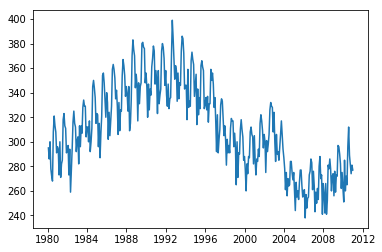

In [25]:
plt.plot(birth)

## 2. Split into Train-Test

Time series data cannot be evaluated using traditional cross validation methods. That leaves us with two options: (1) Splitting the data manually using a certain point in time as our division line between 'past' observations (the training set) and 'future' values (the testing set we can measure our forecasts against). (2) Splitting data into multiple training/testing folds using TimeSeriesSplit from the sklearn library.

Observations: 372
Training Observations: 245
Testing Observations: 127


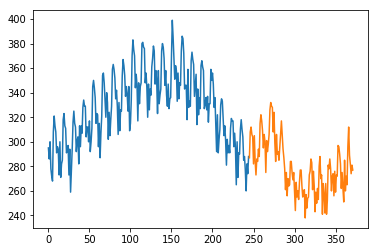

In [5]:
# splitting into training and testing sets using 66-34
X = birth.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

# then plotting it using different colors
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()

Observations: 372
Initializing Observations: 122
Training Observations: 123
Testing Observations: 127


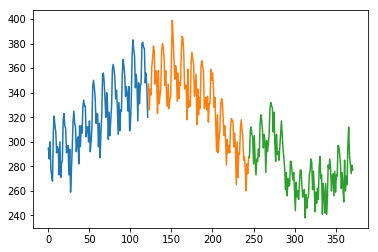

In [27]:
# splitting into training and testing sets using 33-33-34
X = birth.values
train_size_1 = int(len(X) * 0.33)
train_size_2 = int(len(X) * 0.66)
initial, train, test = X[0:train_size_1], X[train_size_1:train_size_2], X[train_size_2:len(X)]
print('Observations: %d' % (len(X)))
print('Initializing Observations: %d' % (len(initial)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

# then plotting it using different colors
plt.plot(initial)
plt.plot([None for i in initial] + [o for o in train] + [None for x in test])
plt.plot([None for i in initial] + [None for t in train] + [x for x in test])
plt.show()

In [30]:
# made train_df and test_df (the latter to be used later)
initial_df = birth[0:122]
train_df = birth[123:245]
test_df = birth[246:372]

## 3. Forecasting Metrics

scale dependent errors (comparing forecast methods on a single data set / cannot be used to make comparisons between series that are on different scales): <br>
MD (mean deviation) $\frac{A_t-F_t}{n}$ <br>
MAD (also called MAE): $\frac{|A_t-F_t|}{n}$ <br>
MSE (mean squared error): $\frac{(A_t-F_t)^2}{n}$ <br>
RMSE (root mean squared error): $\sqrt{\frac{(A_t-F_t)^2}{n}}$ <br>
percentage errors (used to compare forecast performance between different data sets):
MPE, MAPE <br>
also scaled errors

## 4. Time Series Decomposition

can have trend, seasonal, residual <br>
$y_t = T_t+ S_t+\epsilon_t$ <br>
can be additive or multiplicative (can use different forecasting methods accordingly) <br>

statsmodel has a seasonal_decompose() function, it will show observed, can call trend, seasonal, and residual <br>
print(result.trend) <br>
print(result.seasonal) <br>
print(result.resid) <br>
print(result.observed) <br>

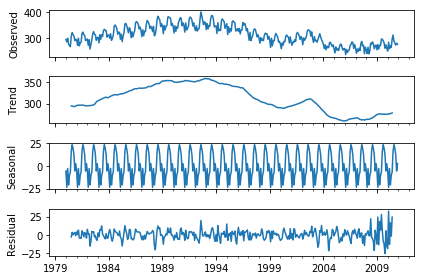

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = birth
result_a = seasonal_decompose(series, model='additive')
result_a.plot()
plt.show()

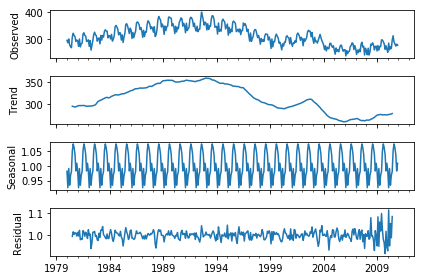

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = birth
result_m = seasonal_decompose(series, model='multiplicative')
result_m.plot()
plt.show()

Note that the various components are on different scale. The trend is roughly on the same scale as the observations, but seasonal fluctuations and residuals are on a different scale. Look at distribution of the residuals. These are very bad--shows that classical decomposition is not powerful enough to capture whatever was happening starting 2008.

## 5.1. Forecasting Methods: Simple Models

naive - "only yesterday matters" <br>
$\hat{y_{t+1}}=x_t$

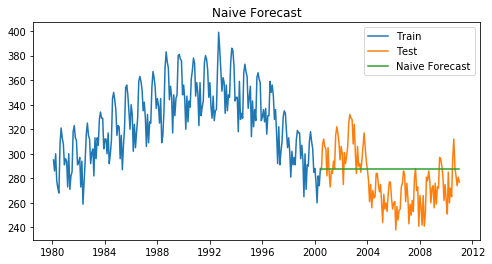

In [12]:
dd= np.asarray(train_df.num_births)
y_hat = test_df.copy()
y_hat['naive'] = dd[len(dd)-1] # this line of code is for one-time forecast
plt.figure(figsize=(8,4))
plt.plot(train_df.index, train_df['num_births'], label='Train')
plt.plot(test_df.index, test_df['num_births'], label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat.naive))
print(rms)

22.962139328026147


cumulative - "everything matters" <br>
$\hat{y_{t+1}}=\frac{\sum_{i=1}^{t}x_i}{t}$

moving average - select how much matters <br>
$\hat{y_{t+1}}=\frac{\sum_{i=t+1-M}^{t}x_i}{M}$

for python implementations, see Methods 1-3 in https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/ <br>
note that $\hat{y}$ depends on forecasting horizon -- here we forecast once after we trained our model on our data

## 5.2. Forecasting Methods: Exponential Smoothing

Exponential Smoothing uses trend and seasonality. It is a whole taxonomy of models. For more detail and ARIMA-ETS equivalences, see here: https://www.otexts.org/fpp/7/6

In [14]:
import pandas as pd
df = pd.read_excel('images/forecasting_methods.xlsx')
df.head()

,Seasonality: none,Seasonality: additive,Seasonality: multiplicative
Trend: none,Simple exponential smoothing,0,Double exponential smoothing
Trend: additive,Holt,0,Holt-Winter
Trend: additive damped,Holt-damped,0,0
Trend: multiplicative,0,0,0
Trend: multiplicative damped,0,0,0


## 5.2.a. Simple Exponential Smoothing (level only)

In [35]:
# THIS IS NOT WORKING NOW !!!!!
# tried 3 alphas between 0.1 and 0.3
from statsmodels.tsa.api import SimpleExpSmoothing

y_hat = test_df.copy()
# make our model
initial_model = SimpleExpSmoothing(train).initialize(initial).fit(smoothing_level=0.3)
fit2 = SimpleExpSmoothing(initial).fit(smoothing_level=0.3)
y_hat['SES'] = fit1.forecast(len(test))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat['SES'], label='Simple_ES')
plt.legend(loc='best')
plt.show()

TypeError: initialize() takes 1 positional argument but 2 were given

In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.SES))
print(rms)

21.447275847375384


## 5.2.b. Holt (level + trend)

Parameters:	
* endog (array-like) – Time series
* exponential (bool, optional) – Type of trend component.
* damped (bool, optional) – Should the trend component be damped.

fit() method parameters:	
* smoothing_level (float, optional) – The alpha value of the simple exponential smoothing, if the value is set then this value will be used as the value.
* smoothing_slope (float, optional) – The beta value of the holts trend method, if the value is set then this value will be used as the value.
* damping_slope (float, optional) – The phi value of the damped method, if the value is set then this value will be used as the value.
* optimized (bool, optional) – Should the values that have not been set above be optimized automatically?

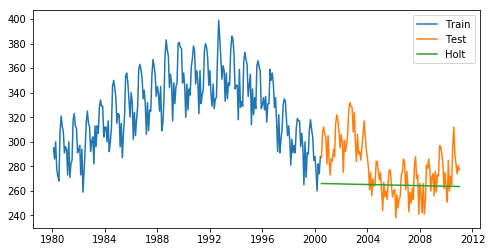

In [82]:
# here we have trend and seasonality, so we will use Holt-Winters
from statsmodels.tsa.api import Holt

y_hat_avg = test_df.copy()
fit1 = Holt(np.asarray(train_df['num_births']), exponential=True).fit(smoothing_level=0.3, smoothing_slope=0.69)
y_hat_avg['Holt'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['Holt'], label='Holt')
plt.legend(loc='best')
plt.show()

In [83]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.Holt))
print(rms)

25.617468832237794


## 5.2.c. Holt damped (level + trend, damped)

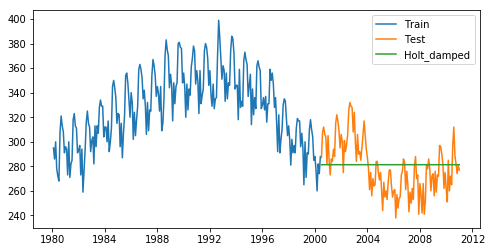

In [40]:
from statsmodels.tsa.api import Holt

y_hat_avg = test_df.copy()
fit1 = Holt(np.asarray(train_df['num_births']), exponential=True, damped=True).fit(smoothing_level=0.3, smoothing_slope=0.7, damping_slope=0.15)
y_hat_avg['Holt_damped'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['Holt_damped'], label='Holt_damped')
plt.legend(loc='best')
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.Holt_damped))
print(rms)

21.409683457760483


## 5.2.d. Double Exponential Smoothing (level + season)

Parameters:	
* endog (array-like) – Time series
* trend ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of trend component.
* damped (bool, optional) – Should the trend component be damped.
* seasonal ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of seasonal component.
* seasonal_periods (int, optional) – The number of seasons to consider for the holt winters.

fit() method Parameters:	
* smoothing_level (float, optional) – The alpha value of the simple exponential smoothing, if the value is set then this value will be used as the value.
* smoothing_slope (float, optional) – The beta value of the holts trend method, if the value is set then this value will be used as the value.
* smoothing_seasonal (float, optional) – The gamma value of the holt winters seasonal method, if the value is set then this value will be used as the value.
* damping_slope (float, optional) – The phi value of the damped method, if the value is set then this value will be used as the value.
* optimized (bool, optional) – Should the values that have not been set above be optimized automatically?
* use_boxcox ({True, False, 'log', float}, optional) – Should the boxcox tranform be applied to the data first? If ‘log’ then apply the log. If float then use lambda equal to float.
* remove_bias (bool, optional) – Should the bias be removed from the forecast values and fitted values before being returned? Does this by enforcing average residuals equal to zero.
* use_basinhopping (bool, optional) – Should the opptimser try harder using basinhopping to find optimal values?

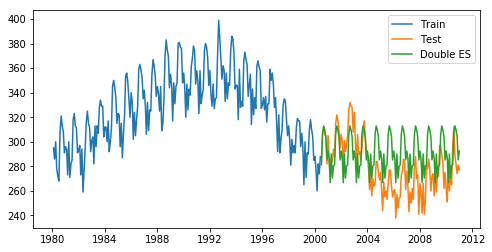

In [91]:
# no trend, just seasonality (multiplicative), no damping
from statsmodels.tsa.api import ExponentialSmoothing

y_hat_avg = test_df.copy()
fit1 = ExponentialSmoothing(np.asarray(train_df['num_births']), seasonal_periods=12, trend=None, seasonal='multiplicative',).fit(smoothing_level=0.19, smoothing_seasonal=0.1)
y_hat_avg['DES'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['DES'], label='Double ES')
plt.legend(loc='best')
plt.show()

In [92]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.DES))
print(rms)

22.396315115277606


## 5.2.e. Holt-Winters (level + trend + season)

Parameters:	
* endog (array-like) – Time series
* trend ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of trend component.
* damped (bool, optional) – Should the trend component be damped.
* seasonal ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of seasonal component.
* seasonal_periods (int, optional) – The number of seasons to consider for the holt winters.

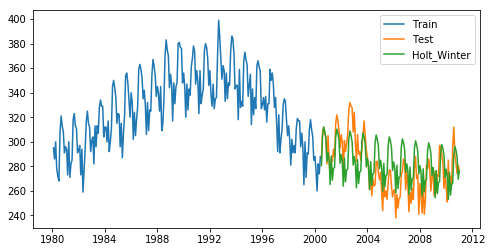

In [95]:
# here we have trend and seasonality, so we will use Holt-Winters
from statsmodels.tsa.api import ExponentialSmoothing

y_hat_avg = test_df.copy()
fit1 = ExponentialSmoothing(np.asarray(train_df['num_births']), seasonal_periods=12, trend='mul', seasonal='mul').fit(smoothing_level=0.19, smoothing_slope=0.005,smoothing_seasonal=0.1)
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test_df))
plt.figure(figsize=(8,4))
plt.plot( train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [96]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df.num_births, y_hat_avg.Holt_Winter))
print(rms)

17.295129844065507


## 5.3. Forecasting Methods: ARIMA

ARIMA uses autocorrelation. If a time series is stationary (see concept below), the correlation between two $y$'s only depends on the lag between them. These correlations between a time series and a lagged version of itself are called autocorrelations. Some exponential smoothing models have ARIMA equivalents and vica versa. (This book gives you the ARIMA-ETS equivalences: https://www.otexts.org/fpp/7/6)

### Stationarity

Image courtesy of www.seanabu.com) <br>

![test](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=1500w)

To test for stationarity: use Augmented Dickey-Fuller test (hypothesis test)<br>
$H_0$: time series is not stationary. <br>
$H_a$: time series is stationary

In [16]:
test=sm.tsa.stattools.adfuller(train_df['num_births'])
print("ADF p-value for training series: {0:2.2f}".format(test[1]))

ADF p-value for training series: 0.71


### ARIMA Components

A non-seasonal ARIMA model: combines differencing with autoregression and a moving average model
* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. <br>

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

### (1) Differencing

In [17]:
# differencing: computing the differences between t and t-1 observations
train_df_diff = train_df['num_births'].diff()[1:]

# running ADF test to see if it made a difference
test = sm.tsa.stattools.adfuller(train_df_diff)
print("ADF p-value for differenced training series: {0:2.2f}".format(test[1]))

ADF p-value for differenced training series: 0.06


In [18]:
# let's do it again!
train_df_diff2 = train_df_diff.diff()[1:]

# running ADF test to see if it made a difference
test = sm.tsa.stattools.adfuller(train_df_diff2)
print("ADF p-value for differenced training series: {0:2.2f}".format(test[1]))

ADF p-value for differenced training series: 0.00


### (2) Moving Average Modeling

$X_t=\mu+\epsilon_t+\theta_1\epsilon_{t-1}+...+\theta_q\epsilon_{t-q} = \displaystyle\sum_{i=1}^{q} \theta_i\epsilon_{t-i} +\mu$ <br>

$\epsilon_t$: noise <br>
$\theta_1\epsilon_{t-1}$: yesterday's noise <br>
$\theta_q\epsilon_{t-q}$: noise from $q$ days ago <br>
moving average models are always stationary <br>
how do I get $q$? I plot autocorrelation -- if it is a MA(q) model, it drops off at $q$ <br>
how do I get $\theta$? regression gives me the coefficients

In [19]:
# moving average MA modeling
from statsmodels.tsa.arima_model import ARIMA
series = train_df

# fit model
model = ARIMA(series, order=(0,0,1)) #the third parameter is the MA order (q)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:             num_births   No. Observations:                  245
Model:                     ARMA(0, 1)   Log Likelihood               -1109.624
Method:                       css-mle   S.D. of innovations             22.405
Date:                Tue, 29 May 2018   AIC                           2225.249
Time:                        09:21:30   BIC                           2235.752
Sample:                    01-31-1980   HQIC                          2229.478
                         - 05-31-2000                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              327.3796      2.262    144.740      0.000     322.947     331.813
ma.L1.num_births     0.5825      0.041     14.138      0.000       0.502       0.663
                            

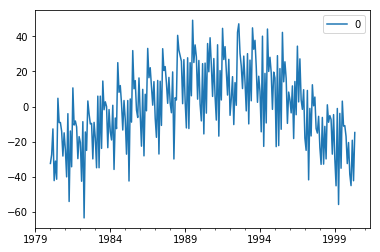

In [20]:
# let's plot the residuals
# line plot of residual errors
# (suggests that there is still trend & seasonality not captured by the model)
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

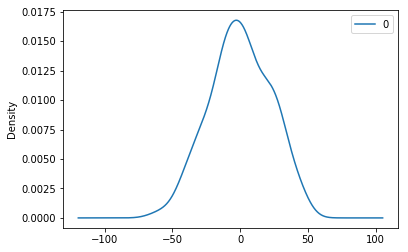

In [21]:
# density plot of residual errors
#(suggests the errors are not quite Gaussian, but are centered on zero)
residuals.plot(kind='kde')

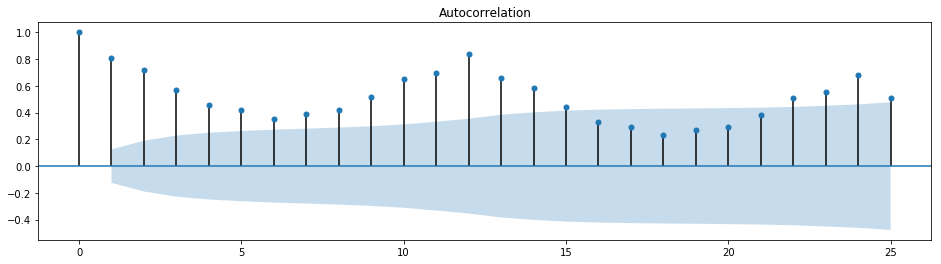

In [22]:
# to see how many time periods to pick: plot autocorrelation and see where it drops off
from statsmodels.graphics.tsaplots import plot_acf
series = train_df

fig, ax = plt.subplots(1, figsize=(16, 4))
_ = plot_acf(series, lags=25, ax=ax)

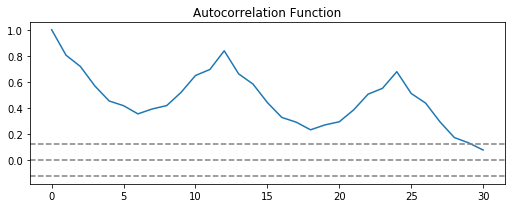

In [23]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_df, nlags=30)

# plot ACF: 
plt.figure(figsize=(14,3))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_df)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.tight_layout()

### (3) Autoregressive Modeling

$X_t=\epsilon_t+\phi_1 X_{t-1}+...+\phi_p X_{t-p} = \displaystyle\sum_{i=1}^{p} \phi_iX_{t-i} +\epsilon_t$ <br>
$\phi_1 X_{t-1}$: yesterday's value <br>
$phi_p X_{t-p}$: value $p$ days ago
autoregressive models aren't always stationary (depends on $\phi$ parameter) <br>
how do I get $p$? autocorrelation always has exponential decay, so that doesn't help <br>
I plot partial autocorrelation -- if it is an AR(p) model, it drops off at $p$ <br>
how do I get $\phi$? regression gives me the coefficients

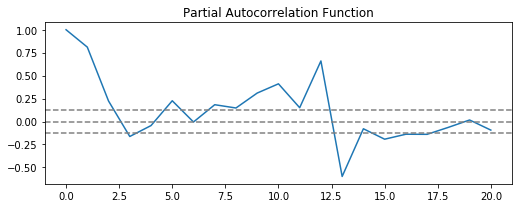

In [24]:
# autoregressive AR modeling
# to see how many time periods to pick: plot autocorrelation and see where it drops off
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_pacf = pacf(train_df, nlags=20, method='ols')

# plot PACF:
plt.figure(figsize=(14,3))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_df)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

ARIMA - you take a difference until you get an ARMA model <br>
$Y_t = \nabla^d X_t$ <br>
$X_t$: ARIMA model <br>
$\nabla^d$ differenced $d$ times <br>
creating $Y_t$ ARMA model <br>
$Y_t = \mu+\phi_1 Y_{t-1}+...+\phi_p Y_{t-p}+\epsilon_t+\theta_1\epsilon_{t-1}+...+\theta_q\epsilon_{t-q}$

Steps to ARIMA (Box-Jenkins Method):
1. Visualize
2. Stationarize (check with Dickey-Fuller)
3. Find optimal parameters to p,d,q with ACF and PACF plots
4. Build ARIMA model
5. Predict and score

#### 1. Visualize

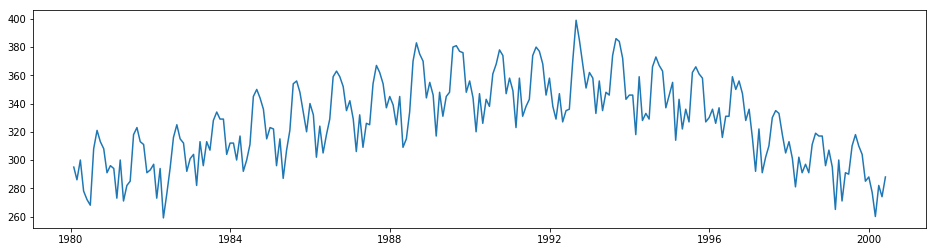

In [25]:
# visualize
plt.figure(figsize=(16,4))
plt.plot(train_df)

#### 2. Stationarize

In [26]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.DataFrame.rolling(timeseries, window=12, center=False).mean()
    rolstd = pd.DataFrame.rolling(timeseries, window=12, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

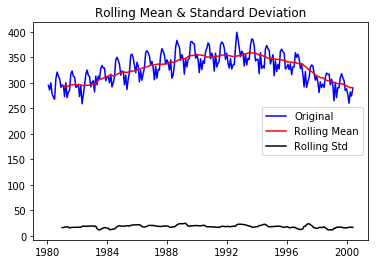

Results of Dickey-Fuller Test:
Test Statistic                  -1.102790
p-value                          0.713958
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [27]:
test_stationarity(train_df['num_births'])

In [28]:
# variation in std is very small but the mean varies over time (trend)

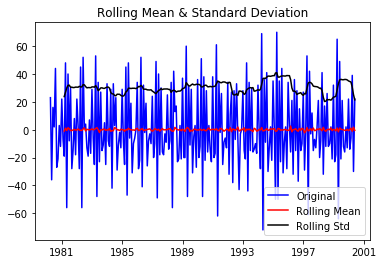

Results of Dickey-Fuller Test:
Test Statistic                -9.790885e+00
p-value                        6.358284e-17
#Lags Used                     1.500000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


In [29]:
# let's see how the differenced series does
train_df_diff = train_df.diff()[1:]
train_df_diff2 = train_df_diff.diff()[1:]
test_stationarity(train_df_diff2['num_births'])

#### 3. Find optimal parameters to p,d,q with ACF and PACF plots

In [30]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_df_diff2, nlags=14)
lag_pacf = pacf(train_df_diff2, nlags=14, method='ols')

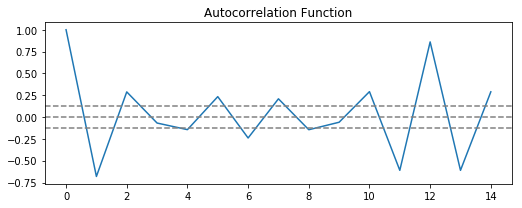

In [31]:
# plot ACF: 
plt.figure(figsize=(14,3))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_df_diff2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_df_diff2)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.tight_layout()

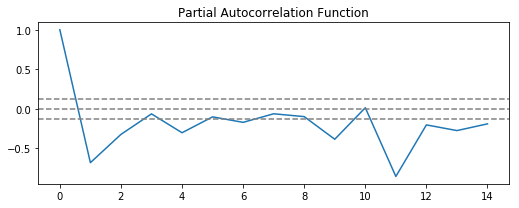

In [32]:
# plot PACF:
plt.figure(figsize=(14,3))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_df_diff2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_df_diff2)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

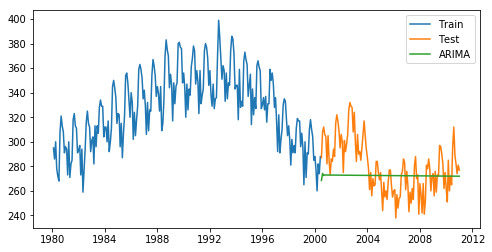

In [35]:
# so we have p=1, d=2, amd q=1
# now let's fit model and plot predictions
from statsmodels.tsa.arima_model import ARIMA

y_hat_avg = test_df.copy()
fit = ARIMA(train_df, order=(1,2,1)).fit()
y_hat_avg['ARIMA'] = fit.predict(start="2000-06-30", end="2010-12-31", dynamic=True, typ='levels')
plt.figure(figsize=(8,4))
plt.plot(train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.show()

In [96]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_df, y_hat_avg.ARIMA))
print(rms)

280.44115652598487


In [97]:
# parameter search for ARIMA (1,2,1)
parameters = [
    {'AR': 1, 'MA': 0},
    {'AR': 2, 'MA': 0},
    {'AR': 3, 'MA': 0},
    {'AR': 1, 'MA': 1},
    {'AR': 2, 'MA': 1},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(train_df, order=(params['AR'], 2, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 2, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(1, 2, 0) AIC: 2180.649048261742
ARIMA(2, 2, 0) AIC: 2155.7379222236914
ARIMA(3, 2, 0) AIC: 2156.7277448745626
ARIMA(1, 2, 1) AIC: 2085.6067183625773
ARIMA(2, 2, 1) AIC: 2085.299532846371
ARIMA(3, 2, 1) AIC: 2086.9719195197995


## 5.3.b. Forecasting Methods: SARIMA

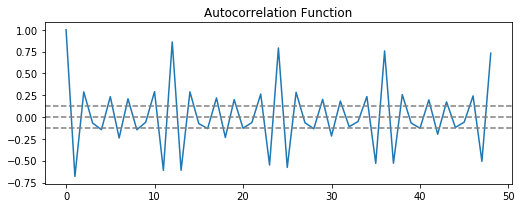

In [160]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_df_diff2, nlags=48)

# plot ACF: 
plt.figure(figsize=(14,3))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_df_diff2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_df_diff2)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.tight_layout()

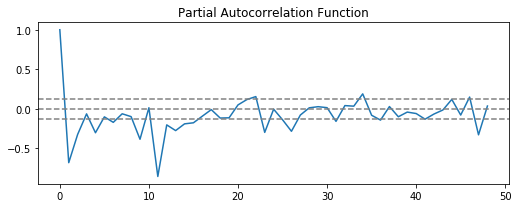

In [159]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_pacf = pacf(train_df_diff2, nlags=48, method='ols')

# plot PACF:
plt.figure(figsize=(14,3))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_df_diff2)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_df_diff2)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [107]:
test_df.tail()

,num_births
2010-08-31,289
2010-09-30,282
2010-10-31,274
2010-11-30,281
2010-12-31,277


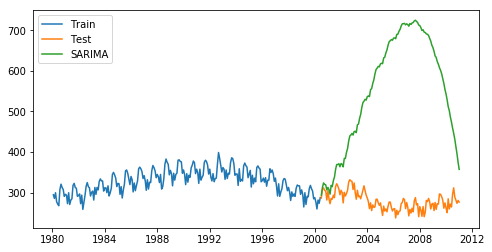

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
y_hat_avg = test_df.copy()
fit1 = SARIMAX(train_df['num_births'], order=(1, 2, 0), seasonal_order=(1,0,0,12), trend='ct').fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2000-06-30", end="2010-12-31", dynamic=True, typ='levels')
plt.figure(figsize=(8,4))
plt.plot(train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [50]:
rms = sqrt(mean_squared_error(test_df, y_hat_avg.SARIMA))
print(rms)

310.6195522878298


## 5.4. Forecasting Models: Prophet()

In [53]:
# imports 
from fbprophet import Prophet

In [54]:
# prophet requires the variable names in the time series to be
# y for target and ds for Datetime
training = train_df.copy()
training['ds'] = training.index
training['y'] = training['num_births']
training.drop(['num_births'],axis = 1, inplace = True)

In [55]:
test_df.describe()

,num_births
count,127.000000
mean,279.496063
std,21.413864
min,238.000000
25%,262.000000
50%,277.000000
75%,294.000000
max,332.000000


In [56]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)
my_model.fit(training)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/andreafabry/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [57]:
future_dates = my_model.make_future_dataframe(periods=127, freq='M')
future_dates.head()
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
367,2010-08-31,181.739042,121.385189,242.568915
368,2010-09-30,176.537993,115.854415,237.339475
369,2010-10-31,169.948538,109.091722,229.096675
370,2010-11-30,147.185430,86.368157,206.555330
371,2010-12-31,154.241185,92.369145,218.556106


In [58]:
forecast.head()
forecast = forecast.set_index('ds')
forecast_slice=forecast[245:372]
forecast_df = forecast_slice["yhat"]
forecast_df.head()

ds
2000-06-30    270.295878
2000-07-31    301.787461
2000-08-31    308.403881
2000-09-30    301.187257
2000-10-31    290.489822
Name: yhat, dtype: float64

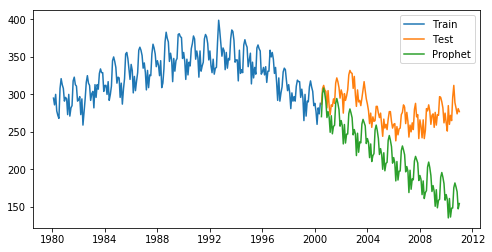

In [59]:
plt.figure(figsize=(8,4))
plt.plot(train_df['num_births'], label='Train')
plt.plot(test_df['num_births'], label='Test')
plt.plot(forecast_slice['yhat'], label='Prophet')
plt.legend(loc='best')
plt.show()

In [60]:
rms = sqrt(mean_squared_error(test_df['num_births'], forecast_slice['yhat']))
print(rms)

69.72272004243916


## 6. Forecasting Methods: Causality & Patterns

Dynamic regression: regression model with ARIMA errors

$Y_t=\beta_0 + Y_{t-1}\beta_1 + Y_{t-2}\beta_2 + ... + Y_{t-n}\beta_n + \epsilon$ <br>
reimagine the residual error $\epsilon$ from the regression equation as an ARIMA model, apply ARIMA until the error from the ARMA model is just white noise. 

This is the algorithm:
1. Check that the forecast variable and all predictors are stationary. If not, apply differencing until all variables are stationary. Where appropriate, use the same differencing for all variables to preserve interpretability.
2. Fit the regression model with AR(2) errors for non-seasonal data or ARIMA$(2,0,0)(1,0,0)_m$ errors for seasonal data.
3. Calculate the errors ($n_t$) from the fitted regression model and identify an appropriate ARMA model for them.
4. Re-fit the entire model using the new ARMA model for the errors.
5. Check that the $e_t$ series looks like white noise.